# Cryptocurrency Prediction

Over $40 billion worth of cryptocurrencies are traded every day. They are among the most popular assets for speculation and investment, yet have proven wildly volatile. Fast-fluctuating prices have made millionaires of a lucky few, and delivered crushing losses to others. Could some of these price movements have been predicted in advance?

In this competition, you'll use your machine learning expertise to forecast short term returns in 14 popular cryptocurrencies. We have amassed a dataset of millions of rows of high-frequency market data dating back to 2018 which you can use to build your model. Once the submission deadline has passed, your final score will be calculated over the following 3 months using live crypto data as it is collected.

The simultaneous activity of thousands of traders ensures that most signals will be transitory, persistent alpha will be exceptionally difficult to find, and the danger of overfitting will be considerable. In addition, since 2018, interest in the cryptomarket has exploded, so the volatility and correlation structure in our data are likely to be highly non-stationary. The successful contestant will pay careful attention to these considerations, and in the process gain valuable insight into the art and science of financial forecasting.

G-Research is Europe’s leading quantitative finance research firm. We have long explored the extent of market prediction possibilities, making use of machine learning, big data, and some of the most advanced technology available. Specializing in data science and AI education for workforces, Cambridge Spark is partnering with G-Research for this competition. 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from scipy.stats import zscore
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")


In [2]:
assets = pd.read_csv('./data/asset_details.csv')
train = pd.read_csv('./data/train.csv')

## Assets Table

Assets table contains information regarding the sold assets and the corresponding cryptocurrencies. It also shows the weight associated to each asset id.

In [3]:
assets.set_index(['Asset_ID'], inplace=True)
assets.sort_index(inplace=True)
assets

,Weight,Asset_Name
Asset_ID,,
0,4.304065,Binance Coin
1,6.779922,Bitcoin
2,2.397895,Bitcoin Cash
3,4.406719,Cardano
4,3.555348,Dogecoin
5,1.386294,EOS.IO
6,5.894403,Ethereum
7,2.079442,Ethereum Classic
8,1.098612,IOTA


## Train table

Contains the time-series data that will be used to train and validate the machine learning algorithm for the forecasting task. It provides information organized into several columns:
* **timestamp**: index of the time series, it provides information regarding the unit of time
* **Asset_ID**:  identifier of the asset, more information about this in the assets table
* **Count**:     number of the traded assets / time unit
* **Open**:      "open" price / time unit
* **High**:      "high" price / time unit
* **Low**:       "low" price / time unit
* **Close**:     "close" price / time unit
* **Volume**:    sum of sold assets / time unit
* **VWAP**:      average price / time unit, weighted by volume
* **Target**:    Residual log-returns for the asset over a 15 minute horizon. 


In order to get acquainted with the data, we're going to follow these three steps:
- showing sample rows of sorted values by timestamp and Asset_ID, 
- check for null values (and eventually deal with them),
- showing sample line graph for the time series data.

In [4]:
train['timestamp'] = train['timestamp'].astype('datetime64[s]')
train.sort_values(['Asset_ID', 'timestamp'], inplace=True)
train.head(10)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
1,2018-01-01 00:01:00,0,5.0,8.5300,8.5300,8.5300,8.5300,78.38,8.530000,-0.014399
9,2018-01-01 00:02:00,0,7.0,8.5300,8.5300,8.5145,8.5145,71.39,8.520215,-0.015875
17,2018-01-01 00:03:00,0,45.0,8.5065,8.5299,8.4848,8.4848,1546.82,8.501394,-0.015410
25,2018-01-01 00:04:00,0,14.0,8.5009,8.5066,8.4744,8.5009,125.80,8.479810,-0.012524
33,2018-01-01 00:05:00,0,5.0,8.5007,8.5007,8.4560,8.4560,125.01,8.458435,-0.005940
41,2018-01-01 00:06:00,0,89.0,8.4560,8.4560,8.3999,8.4000,3765.25,8.403468,-0.005455
49,2018-01-01 00:07:00,0,20.0,8.4000,8.4000,8.3800,8.3958,827.17,8.390564,-0.000644
57,2018-01-01 00:08:00,0,25.0,8.3800,8.4544,8.3800,8.3804,370.04,8.390332,-0.003580
65,2018-01-01 00:09:00,0,16.0,8.3999,8.4519,8.3800,8.3800,1428.91,8.400632,-0.005421
73,2018-01-01 00:10:00,0,1.0,8.3932,8.3932,8.3932,8.3932,12.00,8.393200,-0.005123


In [5]:
train.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24236806 entries, 1 to 24236803
Data columns (total 10 columns):
 #   Column     Non-Null Count     Dtype         
---  ------     --------------     -----         
 0   timestamp  24236806 non-null  datetime64[ns]
 1   Asset_ID   24236806 non-null  int64         
 2   Count      24236806 non-null  float64       
 3   Open       24236806 non-null  float64       
 4   High       24236806 non-null  float64       
 5   Low        24236806 non-null  float64       
 6   Close      24236806 non-null  float64       
 7   Volume     24236806 non-null  float64       
 8   VWAP       24236797 non-null  float64       
 9   Target     23486468 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 2.0 GB


In [6]:
train.dropna(inplace=True)

In [7]:
train.describe()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
count,2.348646e+07,2.348646e+07,2.348646e+07,2.348646e+07,2.348646e+07,2.348646e+07,2.348646e+07,2.348646e+07,2.348646e+07
mean,6.224257e+00,2.954028e+02,1.476051e+03,1.479876e+03,1.472882e+03,1.476050e+03,2.947317e+05,NaN,7.121863e-06
std,4.099476e+00,8.796244e+02,6.119951e+03,6.129966e+03,6.110473e+03,6.119956e+03,2.471421e+06,NaN,5.679042e-03
min,0.000000e+00,1.000000e+00,1.170400e-03,1.195000e-03,2.000000e-04,1.171400e-03,-3.662812e-01,-inf,-5.093509e-01
25%,3.000000e+00,2.200000e+01,2.808670e-01,2.819000e-01,2.800000e-01,2.808736e-01,1.493896e+02,2.808644e-01,-1.694353e-03
50%,6.000000e+00,6.900000e+01,1.486842e+01,1.489000e+01,1.484400e+01,1.486866e+01,1.332360e+03,1.486720e+01,-4.289820e-05
75%,9.000000e+00,2.310000e+02,2.349650e+02,2.353800e+02,2.345200e+02,2.349686e+02,2.911512e+04,2.349653e+02,1.601519e-03
max,1.300000e+01,1.650160e+05,6.480594e+04,6.490000e+04,6.467053e+04,6.480854e+04,7.597554e+08,inf,9.641699e-01


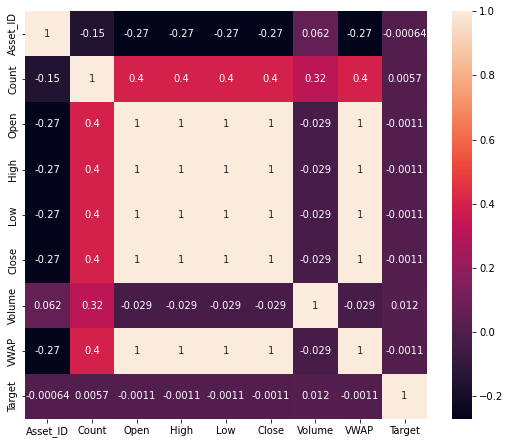

In [8]:
plt.figure(figsize=(9,7.5))
cor = train.corr(method='pearson')
sns.heatmap(cor, annot=True)
plt.show()

According to this correlation plot, the open, close, high and low values are highly correlated, hence we can treat these as a single time series for every currency. We can get rid of VWAP since it's a linearly dependent feature with respect to OHLC values.

In [9]:
binance = train[train['Asset_ID']==0]
bc      = train[train['Asset_ID']==1]
bc_cash = train[train['Asset_ID']==2]
cardano = train[train['Asset_ID']==3]
doge    = train[train['Asset_ID']==4]
eos     = train[train['Asset_ID']==5]
eth     = train[train['Asset_ID']==6]
eth_cl  = train[train['Asset_ID']==7]
iota    = train[train['Asset_ID']==8]
lite    = train[train['Asset_ID']==9]
maker   = train[train['Asset_ID']==10]
monero  = train[train['Asset_ID']==11]
stellar = train[train['Asset_ID']==12]
tron    = train[train['Asset_ID']==13]

## Bitcoin Currency

Let's focus on only the Bitcoin time series and carry out some visualization and analysis. The idea here is to get some information regarding the trend, the seasonality and the irregularity through a resampling followed by  a decomposition of the time series. 

In [10]:
bc = train[train['Asset_ID']==1]

bc = bc.drop(columns=['Asset_ID', 'VWAP'])

bc = bc.set_index('timestamp')

In [11]:
bc.head(61)

,Count,Open,High,Low,Close,Volume,Target
timestamp,,,,,,,
2018-01-01 00:01:00,229.0,13835.194,14013.8,13666.11,13850.176000,31.550062,-0.014643
2018-01-01 00:02:00,235.0,13835.036,14052.3,13680.00,13828.102000,31.046432,-0.015037
2018-01-01 00:03:00,528.0,13823.900,14000.4,13601.00,13801.314000,55.061820,-0.010309
2018-01-01 00:04:00,435.0,13802.512,13999.0,13576.28,13768.040000,38.780529,-0.008999
2018-01-01 00:05:00,742.0,13766.000,13955.9,13554.44,13724.914000,108.501637,-0.008079
...,...,...,...,...,...,...,...
2018-01-01 00:57:00,351.0,13618.094,13807.3,13456.37,13579.912000,51.265423,-0.003617
2018-01-01 00:58:00,254.0,13601.564,13802.6,13452.56,13619.516000,51.971832,-0.005290
2018-01-01 00:59:00,249.0,13625.242,13802.6,13471.62,13646.514000,34.515685,-0.004737


Let's plot the OHCL values. 

For visualization purposes, we're going to resample the time series at hour granularity while we'll keep the original granularity for the training/test step.

In [12]:
bc_hourly    = bc.resample('h').mean().dropna()
bc_quarterly = bc.resample('4M').mean().dropna()

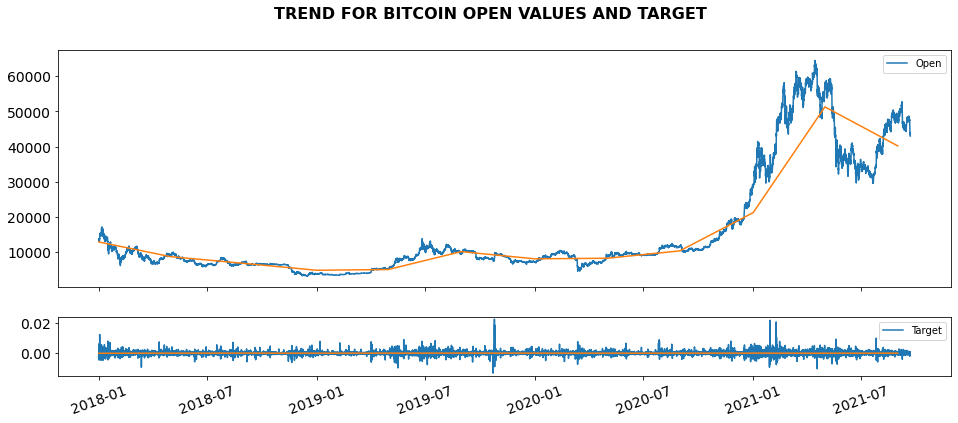

In [13]:
fig, axis = plt.subplots(2, 1, figsize=(16,6), gridspec_kw={'height_ratios': [4, 1]}, sharex=True)

fig.suptitle('TREND FOR BITCOIN OPEN VALUES AND TARGET', fontsize=16, fontweight='bold')

ax = axis[0]
ax.plot(bc_hourly.index, bc_hourly['Open'])
ax.plot(bc_quarterly.index - pd.Timedelta('30d'), bc_quarterly['Open'])
ax.legend(labels=['Open'])
ax.tick_params(axis='y', labelsize=14)

ax = axis[1]
ax.plot(bc_hourly.index, bc_hourly['Target'])
ax.plot(bc_quarterly.index - pd.Timedelta('30d'), bc_quarterly['Target'])
ax.legend(labels=['Target'])
ax.tick_params(axis='y', labelsize=14)

plt.xticks(fontsize=14, rotation=20)
plt.show()


## Stationarity

Stationarity is a characteristic that time series may have to ensure that their statistical properties are constant in time. Ensuring this property helps machine learning algorithms in the prediction of future values. Using some preprocessing techniques we will ensure the following constraints are satisfied by the time series:
* the mean is constant 
* the variance is constant
* there is no seasonality

In [144]:
ts = bc_hourly['Open']

In [145]:
# H0: it is not stationary
# H1: it is stationary

def adfuller_test(time_series):
    print('>> Adfuller test')
    results = adfuller(time_series)
    labels = ['Test Statistic', 'p-value', 'lags', 'number of observations']
    for value, label in zip(results, labels):
        print(' -', label, ':', str(value))
    if results[1] <= 0.05:
        print('\nSucceeded: ts is stationary')
    else:
        print('\nFailed: ts is not stationary')

In [146]:
adfuller_test(ts)

>> Adfuller test
 - Test Statistic : -0.26950712045837
 - p-value : 0.929713382969379
 - lags : 48
 - number of observations : 32564

Failed: ts is not stationary


The current time series is not stationary, which is something expected by seeing the previously plotted curve. 

### Stationarity >> Mean

In order to ensure that the mean is centred, we're going to consider the transformed time series that considers the difference between time "t" and time "t-1".

In [147]:
dif_lagged = ts-ts.shift(1)
dif_lagged.head()

timestamp
2018-01-01 00:00:00           NaN
2018-01-01 01:00:00   -113.183686
2018-01-01 02:00:00   -162.547513
2018-01-01 03:00:00    138.814692
2018-01-01 04:00:00      0.292717
Name: Open, dtype: float64

<AxesSubplot:xlabel='timestamp'>

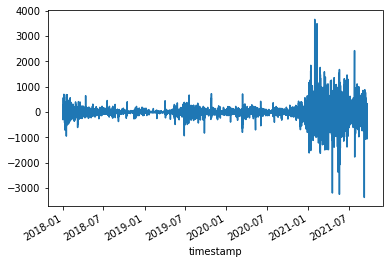

In [148]:
dif_lagged.plot()

In [160]:
def compare_plots(ts1, ts2, sharex=True, sharey=True):
    _, axis = plt.subplots(1, 2, figsize=(16,5), sharex=sharex, sharey=sharey)
    axis[0].plot(ts1)
    axis[1].plot(ts2)
    plt.show()

In [161]:
# rolling over months
rolling_means_ts = dif_lagged.rolling(24*30).mean()          
expanding_means_ts = dif_lagged.expanding().mean()

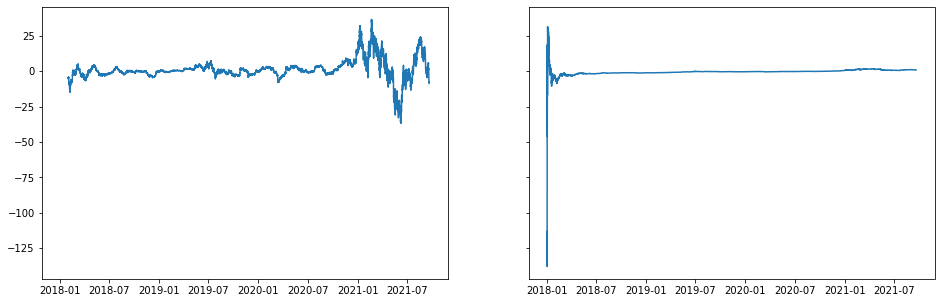

In [162]:
compare_plots(rolling_means_ts, expanding_means_ts)

In [151]:
means_df = pd.DataFrame(pd.concat([rolling_means_ts, expanding_means_ts], axis=1))
means_df.columns = ['rolling', 'expanding']
means_df.describe()

,rolling,expanding
count,31893.000000,32612.000000
mean,1.095652,-0.391739
std,7.113805,2.150722
min,-36.777287,-137.865599
25%,-1.512623,-1.071480
50%,0.279429,-0.291522
75%,2.842793,-0.018405
max,36.642297,31.488083


On average we have the ts mean around the zero value. Following Z-score normalization will adjust the proportions of the values and the means. 


In [152]:
zscored_ts = zscore(dif_lagged.dropna())

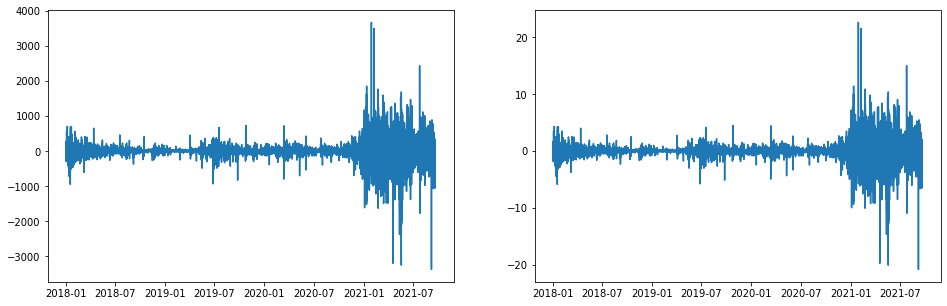

In [153]:
compare_plots(dif_lagged, zscored_ts, sharey=False)

In [154]:
zscored_ts.head()

timestamp
2018-01-01 01:00:00   -0.703484
2018-01-01 02:00:00   -1.007884
2018-01-01 03:00:00    0.850454
2018-01-01 04:00:00   -0.003736
2018-01-01 05:00:00    0.377371
Name: Open, dtype: float64

### Stationarity >> Variance

Let's take a look at the variances over time for the updated ts.

<AxesSubplot:xlabel='timestamp'>

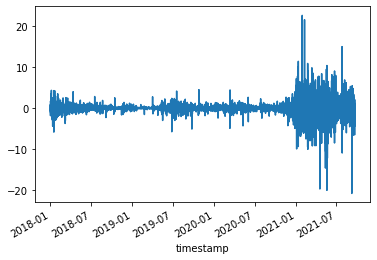

In [155]:
zscored_ts.plot()

In [156]:
# rolling over months
rolling_vars_ts = zscored_ts.rolling(24*30).var()
expanding_vars_ts = zscored_ts.expanding().var()

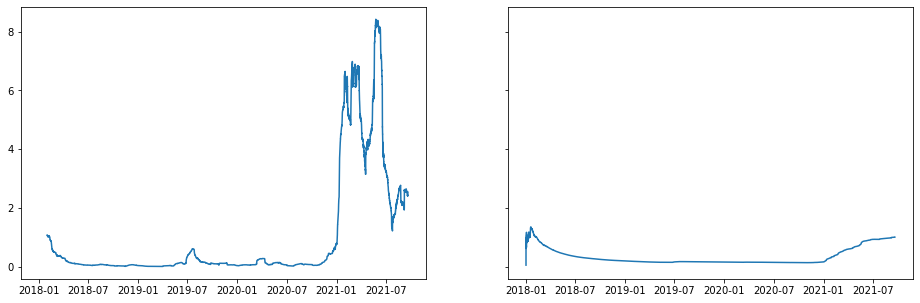

In [157]:
compare_plots(rolling_vars_ts, expanding_vars_ts)

Concerning the variance, it's not stationary as soon as there's an issue with the last part of the ts. In order to fix that and still keeping the mean of the ts to 0, we'll bring the ts in the \[-1,1\] range of values by applying square roots. This operation will squish down big values and emphasize smaller values.

In [173]:
sqrt_zscored_ts = zscored_ts.apply(lambda x: np.sqrt(x) if x > 0 else -np.sqrt(-x))

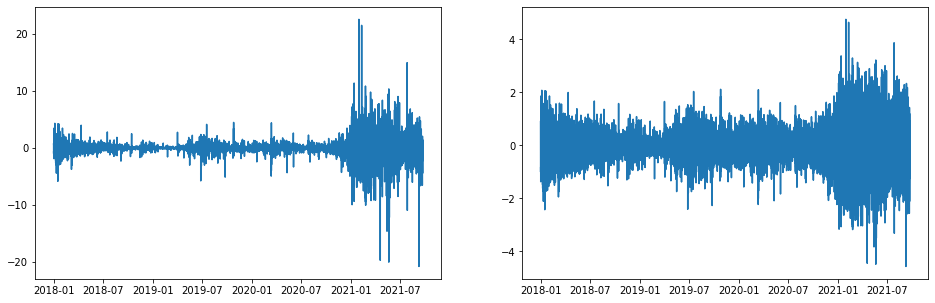

In [174]:
compare_plots(zscored_ts, sqrt_zscored_ts, sharey=False)

Let's try further nth roots for the ts.

In [175]:
def sqrt_nth_ts(ts, power):
    return ts.apply(lambda x: np.power(x,1/power) if x > 0 else -np.power(-x,1/power))

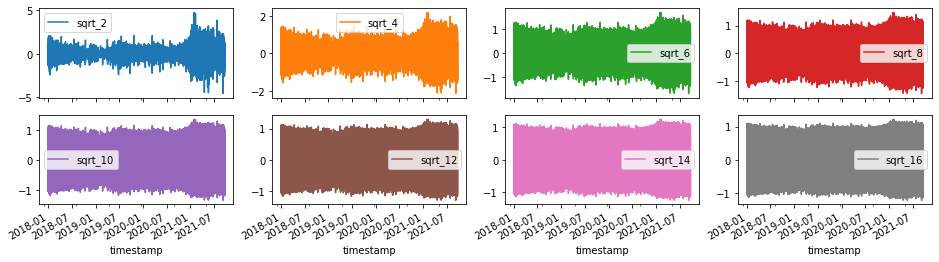

In [201]:
nths = [2, 4, 6, 8, 10, 12, 14, 16]

sqrt_nths_ts = [sqrt_nth_ts(zscored_ts,n) for n in nths]
sqrt_nths_ts = pd.DataFrame(pd.concat(sqrt_nths_ts, axis=1))
sqrt_nths_ts.columns = ['sqrt_'+str(n) for n in nths]

sqrt_nths_ts.plot(
    subplots = True, 
    figsize = (16,4), 
    layout = (2,4)
)

plt.show()

8th square root seems to be a good compromise with respect to the other ones. 

In [210]:
sqrt8_ts = sqrt_nth_ts(zscored_ts,8)
sqrt8_ts.head()

timestamp
2018-01-01 01:00:00   -0.956989
2018-01-01 02:00:00   -1.000982
2018-01-01 03:00:00    0.979956
2018-01-01 04:00:00   -0.497227
2018-01-01 05:00:00    0.885311
Name: Open, dtype: float64

Let's take a look at the means and variances for this ts.

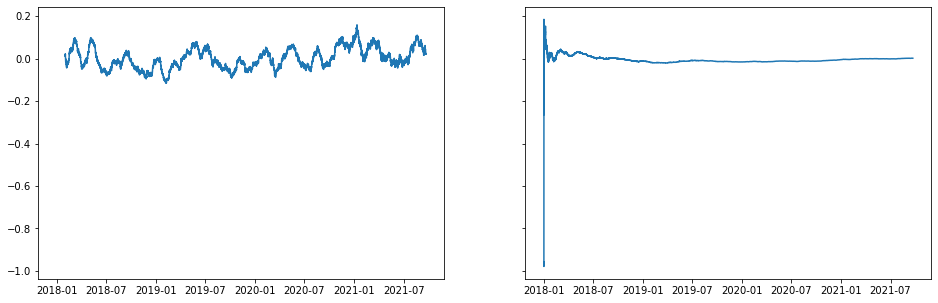

In [214]:
compare_plots(sqrt8_ts.rolling(24*30).mean(), sqrt8_ts.expanding().mean())

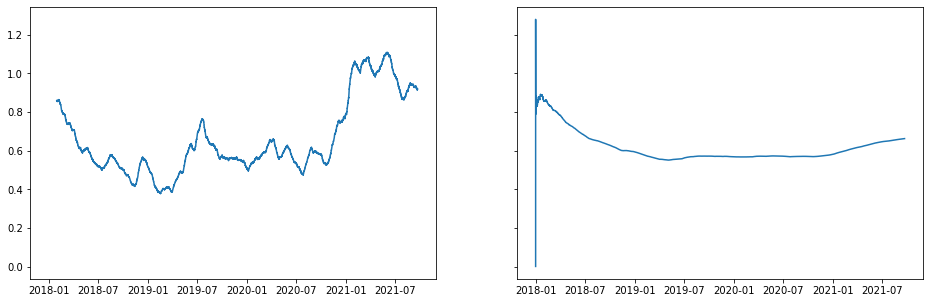

In [217]:
compare_plots(sqrt8_ts.rolling(24*30).var(), sqrt8_ts.expanding().var())

The trend of the overall curve is positive and follows an exponential shape. For this reason we could use the logarithm function to begin working on stationarity. See how this reflects on open values by year as well.

In [54]:
bc_log           = np.log(bc)
bc_hourly_log    = np.log(bc_hourly)
bc_daily_log     = np.log(bc_daily)
bc_monthly_log   = np.log(bc_monthly)
bc_quarterly_log = np.log(bc_quarterly)
bc_yearly_log    = np.log(bc_yearly)

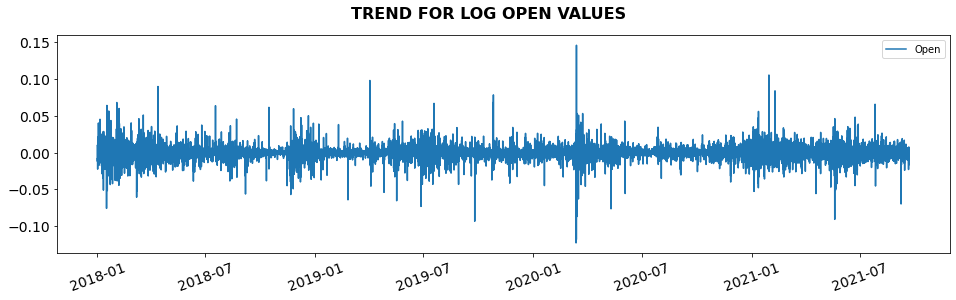

In [61]:
plt.figure(figsize=(16,4))
plt.suptitle('TREND FOR LOG OPEN VALUES', fontsize=16, fontweight='bold')

plt.plot(bc_hourly.index, bc_hourly_log['Open']-bc_hourly_log['Open'].shift(1))
plt.legend(labels=['Open'])
plt.tick_params(axis='y', labelsize=14)

plt.xticks(fontsize=14, rotation=20)
plt.show()


In [60]:
df = bc_daily_log[['Open']]
df['year'] = df.index.year
df['date'] = df.index
df['date'] = df['date'].dt.strftime('%m-%d-%h')
df.reset_index(drop=True, inplace=True)
unstacked_bc = df.set_index(['year', 'date'])['Open'].unstack(-2)

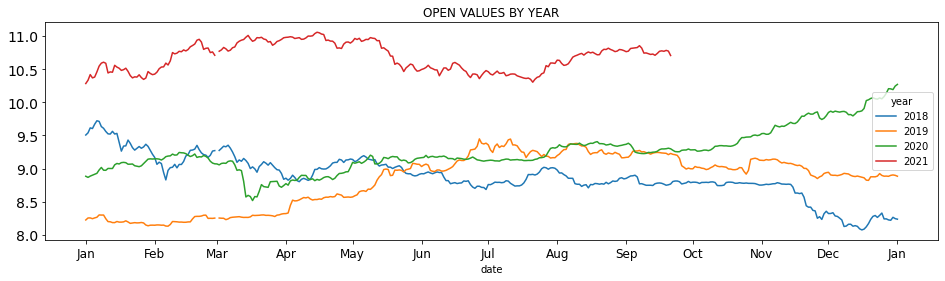

In [61]:
unstacked_bc.plot(
    kind = 'line',
    figsize = (16, 4),
    title = 'OPEN VALUES BY YEAR',
    fontsize = 14
)

plt.xticks(fontsize=12)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.show()

In [122]:
ts = bc_hourly_log['Open'].dropna()
ts = ts.iloc[ts.index.year==2021]
ts

timestamp
2018-01-01 00:00:00    9.522754
2018-01-01 01:00:00    9.514438
2018-01-01 02:00:00    9.502373
2018-01-01 03:00:00    9.512685
2018-01-01 04:00:00    9.512707
                         ...   
2018-12-31 19:00:00    8.228229
2018-12-31 20:00:00    8.216039
2018-12-31 21:00:00    8.215144
2018-12-31 22:00:00    8.214912
2018-12-31 23:00:00    8.219674
Name: Open, Length: 8760, dtype: float64

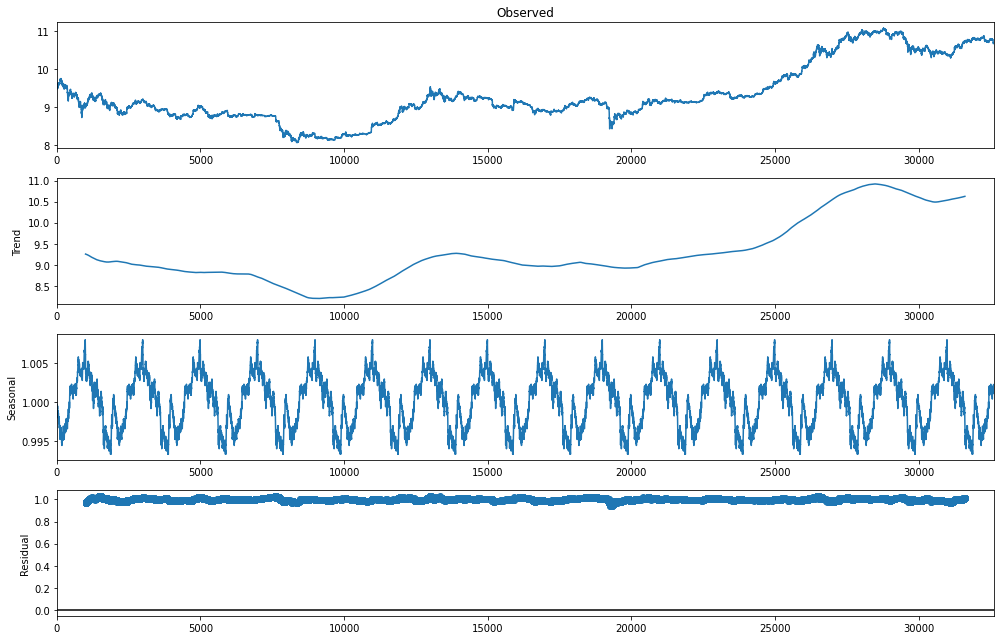

In [149]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(bc_hourly_log['Open'].dropna().values, model='multiplicative', period=2000)

#print(result.trend)
#print(result.seasonal)
#print(result.resid)
#print(result.observed)
result.plot()
plt.rcParams['figure.figsize'] = (14, 9)
plt.show()

## Stationarity

An important step for time series analysis is checking for stationarity. Specifically we're going to check if the Time Series has:
* constant mean
* constant variance
* autovariance that does not depend on time


In [ ]:
bc_roll = bc[['Open', 'High', 'Low', 'Close', 'Target']].rolling(window=24)
bc_roll_mean = bc_roll.mean()
bc_roll_std = bc_roll.std()

In [ ]:
bc_roll_mean

In [ ]:
adfuller_test(bc['Target'])
